In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from sklearn.model_selection import train_test_split
from skimage import io, transform, img_as_float
from torch.utils.data import Dataset, DataLoader
from torch import from_numpy, DoubleTensor, sigmoid, relu
from tqdm import tqdm

from loss_functions import f1_loss

sns.set(style="white")
plt.rcParams['figure.figsize'] = (12, 10)

## Understanding the dataset

In [2]:
train_labels = pd.read_csv("data/train.csv")
train_labels.head()

,Id,Target
0,00070df0-bbc3-11e8-b2bc-ac1f6b6435d0,16 0
1,000a6c98-bb9b-11e8-b2b9-ac1f6b6435d0,7 1 2 0
2,000a9596-bbc4-11e8-b2bc-ac1f6b6435d0,5
3,000c99ba-bba4-11e8-b2b9-ac1f6b6435d0,1
4,001838f8-bbca-11e8-b2bc-ac1f6b6435d0,18


In [3]:
train_labels.shape

(31072, 2)

We have 31k training images to work with. This will later be split into a training and test set. Anticipating that this is a multi-classification/multi-label problem, let's split the Target variable, which are strings, into an array of one-hot-encoded variables.

In [4]:
tmp = train_labels.Target.str.get_dummies(sep=' ')

In [5]:
tmp.columns = map(int, tmp.columns); tmp.head()

,0,1,10,11,12,13,14,15,16,17,...,25,26,27,3,4,5,6,7,8,9
0,1,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
3,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Append this to our train labels dataframe

In [6]:
train_labels = train_labels.join(tmp.sort_index(axis=1))

## Co-occurences

In [7]:
tmp1 = train_labels.iloc[:,2:]

In [8]:
co_occur = tmp1.T.dot(tmp1); co_occur.head()

,0,1,2,3,4,5,6,7,8,9,...,18,19,20,21,22,23,24,25,26,27
0,12885,600,1735,571,97,806,89,1092,5,0,...,279,614,58,1343,325,802,78,3631,115,7
1,600,1254,147,19,52,39,21,56,0,0,...,11,19,0,76,7,45,1,261,0,0
2,1735,147,3621,4,48,59,79,189,11,0,...,18,56,6,216,52,226,12,782,11,1
3,571,19,4,1561,23,14,24,40,4,0,...,5,20,0,35,16,51,3,272,12,0
4,97,52,48,23,1858,5,2,42,0,0,...,16,16,2,135,24,44,8,329,17,1


Now that I have a co-occurence matrix, let's plot it with a heatmap.

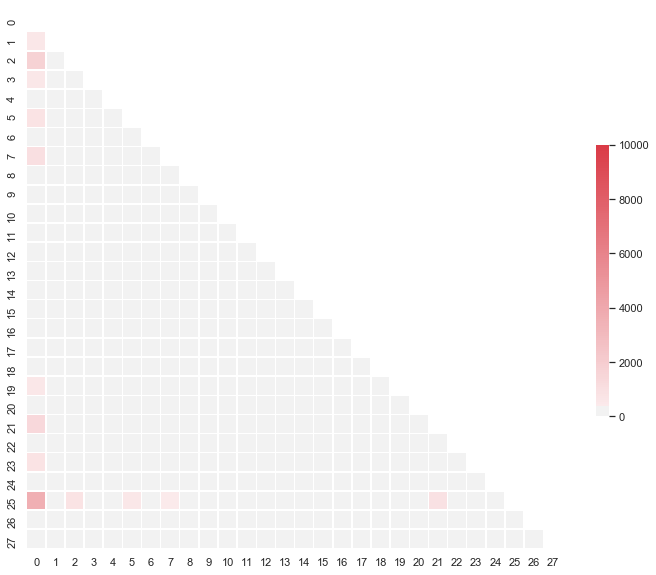

In [9]:
mask = np.zeros_like(co_occur, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(co_occur, mask=mask, cmap=cmap, vmax=10000, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

The above plot doesn't tell me much because most of the variables have so few occurences that few, can be seen above the 1k number of co-occurences. Let's try plotting it on a log base-10 scale.

In [10]:
co_occur1 = co_occur.apply(np.log, args=10)

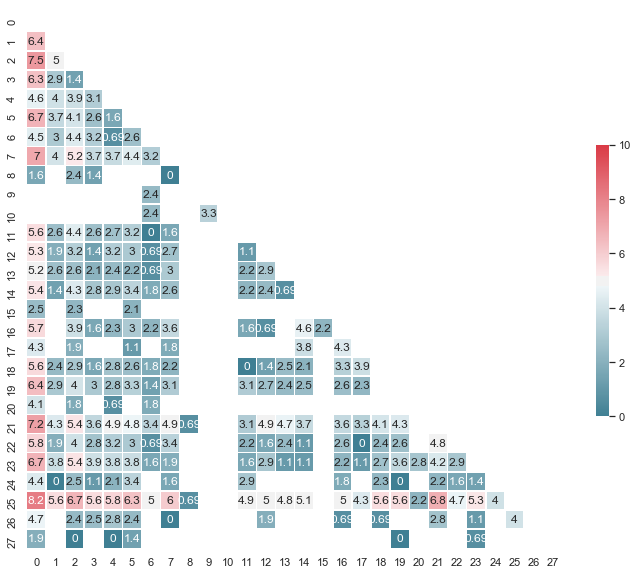

In [11]:
mask = np.zeros_like(co_occur1, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(co_occur1, mask=mask, cmap=cmap, vmax=10, vmin=0, center=5,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True)

This plot is helpful because, while still showing the high frequency of co-occurence protein 0  and 25 have with many other columns, It also shows the lack of co-occurence that protein 8,9 and 10 have with any other proteins. We may be able to use this later.

## Label names

In [12]:
label_names = {
    0:  "Nucleoplasm",  
    1:  "Nuclear membrane",   
    2:  "Nucleoli",   
    3:  "Nucleoli fibrillar center",   
    4:  "Nuclear speckles",
    5:  "Nuclear bodies",   
    6:  "Endoplasmic reticulum",   
    7:  "Golgi apparatus",   
    8:  "Peroxisomes",   
    9:  "Endosomes",   
    10:  "Lysosomes",   
    11:  "Intermediate filaments",   
    12:  "Actin filaments",   
    13:  "Focal adhesion sites",   
    14:  "Microtubules",   
    15:  "Microtubule ends",   
    16:  "Cytokinetic bridge",   
    17:  "Mitotic spindle",   
    18:  "Microtubule organizing center",   
    19:  "Centrosome",   
    20:  "Lipid droplets",   
    21:  "Plasma membrane",   
    22:  "Cell junctions",   
    23:  "Mitochondria",   
    24:  "Aggresome",   
    25:  "Cytosol",   
    26:  "Cytoplasmic bodies",   
    27:  "Rods & rings"
}

## Image reconnaissance

Let's take a look at some of the images and try to imagine what we want our net to find here

In [13]:
DIR = 'data/train_images'
print(len([name for name in os.listdir(DIR) if os.path.isfile(os.path.join(DIR, name))]))

124288


In [14]:
len(train_labels) * 4

124288

Good! The number of files in the train_images directory matches 4x the number of rows in our train_labels dataframe. There is one stained image - red, blue, green, yellow for each image Id. The below code chooses a uniform random sample of 4 images and displays each color.

In [15]:
id_list = train_labels.sample(4).Id.tolist(); id_list

['ac0de89e-bba5-11e8-b2ba-ac1f6b6435d0',
 '1c980c8e-bb9c-11e8-b2b9-ac1f6b6435d0',
 '49a761fa-bbb7-11e8-b2ba-ac1f6b6435d0',
 'fbaebfa8-bb9c-11e8-b2b9-ac1f6b6435d0']

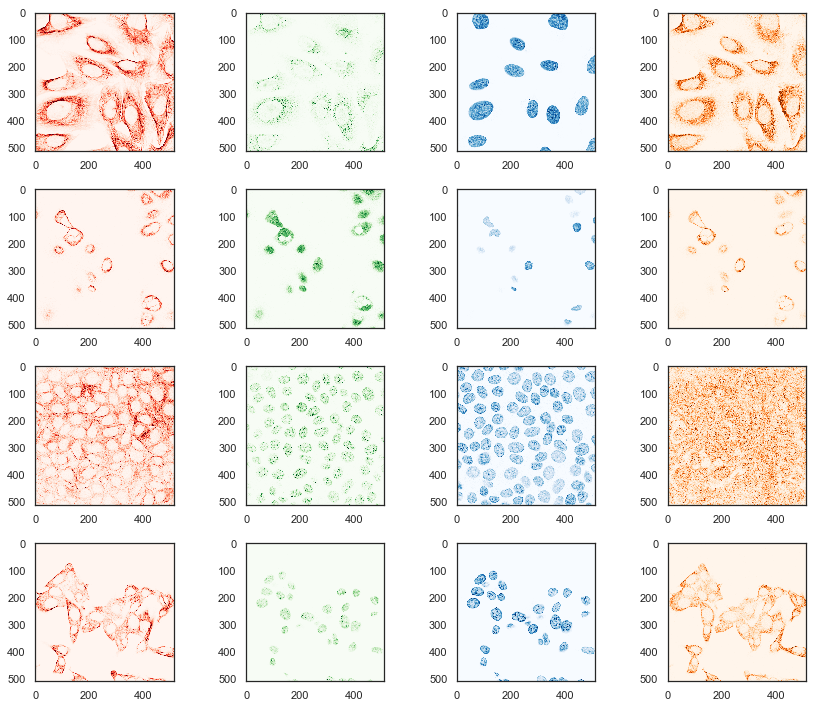

In [16]:
def plot_images_row(img_id, ax_row):
    filters = ['red', 'green', 'blue', 'yellow']
    colormaps = ['Reds', 'Greens', 'Blues', 'Oranges']
    
    for c, ax, cmap in zip(filters, ax_row, colormaps):
        filename = img_id + '_' + c + '.png'
        img=mpimg.imread(os.path.join(DIR, filename))
        imgplot = ax.imshow(img, cmap=cmap)

fig, axes = plt.subplots(nrows=4, ncols=4)

for img_id, ax_row in zip(id_list, axes):
    plot_images_row(img_id, ax_row)
 
plt.tight_layout()

We can see that each color is vaguely reminiscent of the others for the same image. Below is a larger version of one of the images shown in blue.

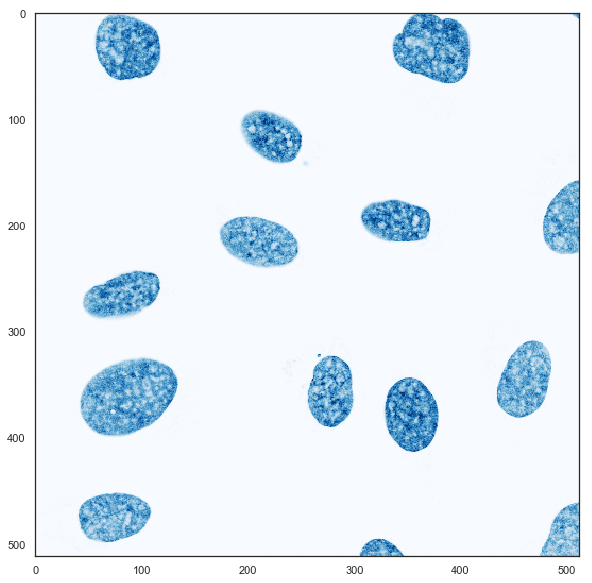

In [17]:
color = 'blue'
filename = id_list[0] + '_' + color + '.png'
img=mpimg.imread(os.path.join(DIR, filename))
plt.imshow(img, cmap="Blues")

## Baseline model

The rest of this notebook is composed of the following steps in order:

1. Load and transform the training datasets using a Dataset class
2. Do the same for the test dataset for use later
3. Define a loss function
4. Define the baseline model
5. Train the network on the training data
6. Test the network on the test data

In [18]:
class TrainImageDataset(Dataset):
    """Fluorescence microscopy images of protein structures training dataset"""

    def __init__(self, csv_file, image_dir, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            image_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.labels = self.to_one_hot(pd.read_csv(csv_file))
        self.image_dir = image_dir
        self.transform = transform

    def to_one_hot(self, df):
        tmp = df.Target.str.get_dummies(sep=' ')
        tmp.columns = map(int, tmp.columns)
        return df.join(tmp.sort_index(axis=1))
    
    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        img_name = self.labels.iloc[idx, 0]
        img_red = img_name + '_red.png'
        img_blue = img_name + '_blue.png'
        img_green = img_name + '_green.png'
        img_yellow = img_name + '_yellow.png'
        img_red = img_as_float(io.imread(os.path.join(self.image_dir, img_red)))
        img_blue = img_as_float(io.imread(os.path.join(self.image_dir, img_blue)))
        img_green = img_as_float(io.imread(os.path.join(self.image_dir, img_green)))
        img_yellow = img_as_float(io.imread(os.path.join(self.image_dir, img_yellow)))
        labels = self.labels.iloc[idx, 2:].values
        labels = labels.astype('int')
        sample = {'image_red': img_red,
                  'image_blue': img_blue,
                  'image_green': img_green,
                  'image_yellow': img_yellow,
                  'labels': labels}

        if self.transform:
            sample = self.transform(sample)

        return sample

In [19]:
train_dataset = TrainImageDataset(csv_file='data/train.csv',
                                    image_dir='data/train_images')

In [20]:
sample = train_dataset[120]

In [21]:
sample

{'image_red': array([[0.        , 0.        , 0.        , ..., 0.00784314, 0.03137255,
         0.02352941],
        [0.        , 0.        , 0.        , ..., 0.        , 0.02745098,
         0.05882353],
        [0.        , 0.        , 0.        , ..., 0.02745098, 0.05490196,
         0.07058824],
        ...,
        [0.        , 0.        , 0.        , ..., 0.22352941, 0.17254902,
         0.08235294],
        [0.        , 0.        , 0.        , ..., 0.09803922, 0.03529412,
         0.02352941],
        [0.        , 0.        , 0.        , ..., 0.02352941, 0.01568627,
         0.01568627]]),
 'image_blue': array([[0.02352941, 0.02352941, 0.03921569, ..., 0.23529412, 0.14117647,
         0.2627451 ],
        [0.05098039, 0.02745098, 0.03921569, ..., 0.15294118, 0.2       ,
         0.14509804],
        [0.01568627, 0.03921569, 0.03529412, ..., 0.19215686, 0.16862745,
         0.17647059],
        ...,
        [0.        , 0.        , 0.        , ..., 0.30588235, 0.46666667,
       

In [22]:
sample['image_red'].shape == sample['image_blue'].shape == \
sample['image_green'].shape ==  sample['image_yellow'].shape

True

In [23]:
len(sample['labels']) == 28

True

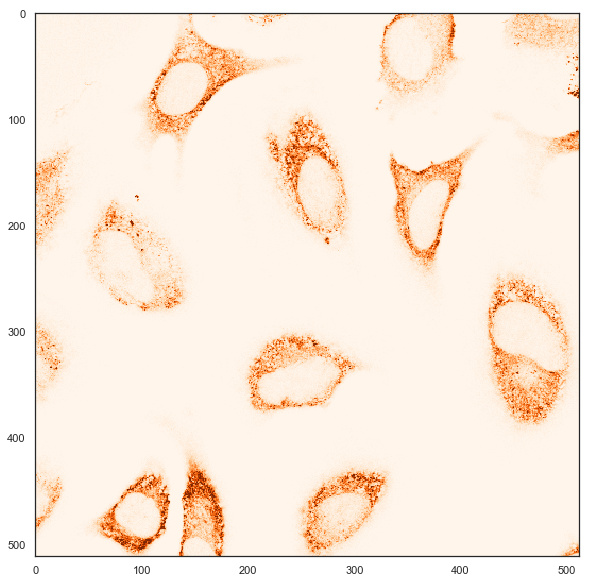

In [24]:
plt.imshow(sample['image_yellow'], cmap="Oranges")

In [25]:
DIR = 'data/test_images'
print(len([name for name in os.listdir(DIR) if os.path.isfile(os.path.join(DIR, name))]))

46808


In [26]:
[name for name in os.listdir(DIR) if os.path.isfile(os.path.join(DIR, name))][:20]

['70c31a84-bac9-11e8-b2b8-ac1f6b6435d0_red.png',
 'a85cef1e-bac5-11e8-b2b7-ac1f6b6435d0_yellow.png',
 'a28d2bfc-bac6-11e8-b2b7-ac1f6b6435d0_green.png',
 '7c6a0764-bac7-11e8-b2b7-ac1f6b6435d0_blue.png',
 'c775fb6e-bacc-11e8-b2b8-ac1f6b6435d0_blue.png',
 '00db3cb8-bac6-11e8-b2b7-ac1f6b6435d0_green.png',
 '971331e2-bad8-11e8-b2b9-ac1f6b6435d0_yellow.png',
 '448d1a26-bad0-11e8-b2b8-ac1f6b6435d0_blue.png',
 'a3310660-bad9-11e8-b2b9-ac1f6b6435d0_green.png',
 '2b28bda0-bacc-11e8-b2b8-ac1f6b6435d0_yellow.png',
 'd5c91512-bacb-11e8-b2b8-ac1f6b6435d0_green.png',
 'edef89fe-bac7-11e8-b2b7-ac1f6b6435d0_yellow.png',
 'd7478dae-bacd-11e8-b2b8-ac1f6b6435d0_yellow.png',
 '4e2606dc-bac7-11e8-b2b7-ac1f6b6435d0_green.png',
 'd2d0f9e8-bac5-11e8-b2b7-ac1f6b6435d0_blue.png',
 '5b83e6ba-bac6-11e8-b2b7-ac1f6b6435d0_yellow.png',
 '5c2ef3e0-bad8-11e8-b2b9-ac1f6b6435d0_blue.png',
 'ee334694-bacc-11e8-b2b8-ac1f6b6435d0_red.png',
 '74993d6e-bad8-11e8-b2b9-ac1f6b6435d0_red.png',
 '9eafcf6a-bacd-11e8-b2b8-ac1f6b6435

In [27]:
class TestImageDataset(Dataset):
    """Fluorescence microscopy images of protein structures test dataset"""

    def __init__(self, image_dir, transform=None):
        """
        Args:
            image_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.image_ids = self.get_image_ids_from_dir_contents(image_dir)
        self.image_dir = image_dir
        self.transform = transform
    
    def get_image_ids_from_dir_contents(self, image_dir):
        all_images = [name for name in os.listdir(image_dir) \
                      if os.path.isfile(os.path.join(image_dir, name))]
        return list(set([name.split('_')[0] for name in all_images]))
        
    def __len__(self):
        return len(self.image_ids)
    
    def __getitem__(self, idx):
        img_name = self.image_ids[idx]
        img_red = img_name + '_red.png'
        img_blue = img_name + '_blue.png'
        img_green = img_name + '_green.png'
        img_yellow = img_name + '_yellow.png'
        img_red = img_as_float(io.imread(os.path.join(self.image_dir, img_red)))
        img_blue = img_as_float(io.imread(os.path.join(self.image_dir, img_blue)))
        img_green = img_as_float(io.imread(os.path.join(self.image_dir, img_green)))
        img_yellow = img_as_float(io.imread(os.path.join(self.image_dir, img_yellow)))
        sample = {'image_red': img_red,
                  'image_blue': img_blue,
                  'image_green': img_green,
                  'image_yellow': img_yellow}

        if self.transform:
            sample = self.transform(sample)

        return sample

In [28]:
test_dataset = TestImageDataset(image_dir='data/test_images')

In [29]:
test_dataset[319]

{'image_red': array([[0.        , 0.        , 0.00784314, ..., 0.        , 0.00392157,
         0.00784314],
        [0.        , 0.        , 0.        , ..., 0.00784314, 0.00784314,
         0.01960784],
        [0.        , 0.00392157, 0.00392157, ..., 0.        , 0.02745098,
         0.03529412],
        ...,
        [0.17647059, 0.16862745, 0.10196078, ..., 0.01176471, 0.        ,
         0.        ],
        [0.05882353, 0.07843137, 0.1254902 , ..., 0.        , 0.        ,
         0.00392157],
        [0.03529412, 0.04705882, 0.12156863, ..., 0.        , 0.00392157,
         0.        ]]),
 'image_blue': array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        ...,
        [0.10980392, 0.03137255, 0.0627451 , ..., 0.        , 0.        ,
       

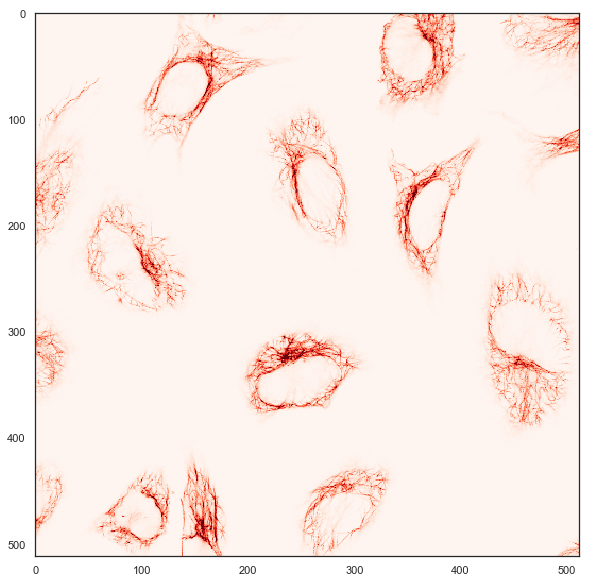

In [30]:
plt.imshow(sample['image_red'], cmap="Reds")

In [31]:
class CombineColors(object):
    """Combines the the image in a sample to a given size."""

    def __call__(self, sample):
        img_red = sample['image_red']
        img_blue = sample['image_blue']
        img_green = sample['image_green']
        img_yellow = sample['image_yellow']
        if 'labels' in sample:
            labels = sample['labels']
        else:
            labels = None
        image = np.dstack((img_red, img_blue, img_green, img_yellow))
        
        return {'image': image, 'labels': labels}

class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        image = sample['image']
        if 'labels' in sample:
            labels = sample['labels']
        else:
            labels = None
        # swap color axis because
        # numpy image: H x W x C
        # torch image: C X H X W
        image = image.transpose((2, 0, 1))
        return {'image': from_numpy(image).type(DoubleTensor),
                'labels': from_numpy(labels).type(DoubleTensor)}

class Normalize(object):
    """Normalize a tensor image with mean and standard deviation.
    Given mean: ``(M1,...,Mn)`` and std: ``(S1,..,Sn)`` for ``n`` channels, 
    this transform will normalize each channel of the input ``torch.*Tensor`` 
    i.e.
    ``input[channel] = (input[channel] - mean[channel]) / std[channel]``
    .. note::
        This transform acts in-place, i.e., it mutates the input tensor.
    Args:
        mean (sequence): Sequence of means for each channel.
        std (sequence): Sequence of standard deviations for each channel.
    """

    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, sample):
        """
        Args:
            tensor (Tensor): Tensor image of size (C, H, W) to be normalized.
        Returns:
            Tensor: Normalized Tensor image.
        """
        image = sample['image']
        if 'labels' in sample:
            labels = sample['labels']
        else:
            labels = None
        transforms.Normalize(self.mean, self.std)(image)
        return {'image': image,
                'labels': labels}

    def __repr__(self):
        return self.__class__.__name__ + '(mean={0}, std={1})'.\
                                            format(self.mean, self.std)

transform = transforms.Compose(
                [CombineColors(),
                 ToTensor()])

In [32]:
protein_image_dataset = TrainImageDataset(csv_file='data/train.csv',
                         image_dir='data/train_images', 
                         transform=transform)
n_images = len(protein_image_dataset)
arr = np.random.choice(n_images, 7000, replace=False)
train_idxs = arr[:int(7000 * .67)]
test_idxs = arr[int(7000 * .67):]
trainset = []
testset = []
print('getting training set...')
for i in tqdm(train_idxs):
    sample = protein_image_dataset[i]
    trainset.append(sample)
print('getting testing set...')
for i in tqdm(test_idxs):
    sample = protein_image_dataset[i]
    testset.append(sample)

  0%|          | 3/4690 [00:00<02:46, 28.21it/s]

getting training set...


  0%|          | 2/2310 [00:00<02:40, 14.40it/s]

getting testing set...


100%|██████████| 2310/2310 [01:50<00:00, 20.95it/s]


In [33]:
trainloader = DataLoader(trainset, batch_size=4,
                         shuffle=True, num_workers=4)

testloader = DataLoader(testset, batch_size=4,
                        shuffle=False, num_workers=4)

In [34]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(4, 6, 5) # 4 channel in, 6 channels out, filter size 5
        self.pool = nn.MaxPool2d(2, 2) # 6 channel in, 6 channels out, filter size 2, stride 2 
        self.conv2 = nn.Conv2d(6, 16, 5) # 6 channel in, 16 channels out, filter size 5
        self.fc1 = nn.Linear(16 * 125 * 125, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 28)

    def forward(self, x):
        x = self.conv1(x)
        x = self.pool(relu(x))
        x = self.conv2(x)
        x = self.pool(relu(x))
        x = x.view(-1, 16 * 125 * 125)
        x = relu(self.fc1(x))
        x = relu(self.fc2(x))
        x = sigmoid(self.fc3(x))
        return x


net = Net().double()

In [35]:
optimizer = optim.SGD(net.parameters(), lr=1e-1, momentum=0.9, weight_decay=1e-4)

In [36]:
for epoch in range(2):  # loop over the dataset multiple times

    training_loss = 0.0
    testing_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        net.train()
        # get the inputs
        inputs, labels = data['image'], data['labels']

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = f1_loss(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        training_loss += loss.item()
        if i % 200 == 199:    # print every 200 mini-batches
            print('[%d, %5d] training loss: %.3f' %
                  (epoch + 1, i + 1, training_loss / 200))
            training_loss = 0.0
    for i, data in enumerate(testloader, 0):
        net.eval()
        # get the inputs
        inputs, labels = data['image'], data['labels']

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = f1_loss(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        testing_loss += loss.item()
        if i % 200 == 199:    # print every 200 mini-batches
            print('[%d, %5d] testing loss: %.3f' %
                  (epoch + 1, i + 1, testing_loss / 200))
            testing_loss = 0.0

print('Finished Training')

[1,   200] training loss: 0.917
[1,   400] training loss: 0.916
[1,   600] training loss: 0.915
[1,   800] training loss: 0.914
[1,  1000] training loss: 0.915
[1,   200] testing loss: 0.914
[1,   400] testing loss: 0.915
[2,   200] training loss: 0.915
[2,   400] training loss: 0.912
[2,   600] training loss: 0.915
[2,   800] training loss: 0.916
[2,  1000] training loss: 0.913
[2,   200] testing loss: 0.914
[2,   400] testing loss: 0.915
Finished Training
